<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/Adjust_Param_Analsysis_NSynth_overlay_instruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import os
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds


label_map = {
    0: 'bass',
    1: 'brass',
    2: 'flute',
    3: 'guitar',
    4: 'keyboard',
    5: 'mallet',
    6: 'organ',
    7: 'reed',
    8: 'string',
    9: 'vocal',
}


# Step 2: Load models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 3: get samples

In [ ]:
import glob
import os

# Assuming 'base_dir' is your directory path
base_dir = '/content/drive/MyDrive/EMR_output/tests/'
csv_dir = '/content/drive/MyDrive/EMR_output/tests/threshold'
file_pattern = os.path.join(csv_dir, '*_emr[0.1*.csv')
files = glob.glob(file_pattern)

plot

In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np

def calculate_accuracy_per_instrument(file_path):
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        true_labels = []
        pred_labels = []
        for row in reader:
            true_labels.append([int(bit) for bit in row[0].split(' ')])
            pred_labels.append([int(bit) for bit in row[1].split(' ')])

    accuracies = []
    for instrument_index in range(10):  # Assuming 10 instruments
        correct_predictions = sum(1 for true, pred in zip(true_labels, pred_labels) if true[instrument_index] == pred[instrument_index])
        accuracy = correct_predictions / len(true_labels)
        accuracies.append(accuracy)
    return accuracies

def extract_thresholds_from_filename(filename):
    start = filename.find('thresholds[') + 11  # Adjust to match the start of the numbers
    end = filename.find('].csv', start)
    thresholds_str = filename[start:end]
    thresholds = [float(t.split(':')[1]) for t in thresholds_str.split('-')]
    return thresholds


# Initialize lists to store accuracies and thresholds for each instrument
instrument_results = {i: {'accuracies': [], 'thresholds': []} for i in range(10)}

for file_path in files:
    thresholds = extract_thresholds_from_filename(file_path)
    accuracies = calculate_accuracy_per_instrument(file_path)
    for i in range(10):
        instrument_results[i]['accuracies'].append(accuracies[i])
        instrument_results[i]['thresholds'].append(thresholds[i])

# Ensure the directory for saving plots exists
plot_save_dir = os.path.join(base_dir, 'threshold/')
os.makedirs(plot_save_dir, exist_ok=True)  # This line creates the directory if it doesn't exist


# Plotting
for i in range(10):
    instrument_name = label_map[i]  # Get the instrument name from the label_map


    results = instrument_results[i]
    # Sort by threshold for plotting
    sorted_indices = np.argsort(results['thresholds'])
    sorted_thresholds = np.array(results['thresholds'])[sorted_indices]
    sorted_accuracies = np.array(results['accuracies'])[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_thresholds, sorted_accuracies, marker='o', linestyle='-', label='Accuracy vs. Threshold')
    plt.title(f'{instrument_name.capitalize()} Accuracy vs. Threshold')  # Use instrument name in the title
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    # plt.savefig(f'{base_dir}threshold/instrument_{i}_threshold_accuracy.png')
    plt.show()

IndexError: list index out of range

highest accuracy by threshold

In [ ]:
# After plotting, add this code to print the highest accuracy and corresponding threshold for each instrument
for i in range(10):
    instrument_name = label_map[i]  # Get the instrument name from the label_map
    results = instrument_results[i]

    # Find the index of the highest accuracy
    max_accuracy_index = np.argmax(results['accuracies'])
    max_accuracy = results['accuracies'][max_accuracy_index]
    corresponding_threshold = results['thresholds'][max_accuracy_index]

    print(f"Highest {instrument_name} accuracy: {max_accuracy:.4f}, corresponding threshold: {corresponding_threshold:.4f}")


Highest Bass accuracy: 0.5855, corresponding threshold: 0.0029
Highest Brass accuracy: 0.6673, corresponding threshold: 0.0007
Highest Flute accuracy: 0.5418, corresponding threshold: 0.1301
Highest Guitar accuracy: 0.5791, corresponding threshold: 0.0096
Highest Keyboard accuracy: 0.5973, corresponding threshold: 0.0001
Highest Mallet accuracy: 0.7300, corresponding threshold: 0.0001
Highest Organ accuracy: 0.5964, corresponding threshold: 0.0007
Highest Reed accuracy: 0.7218, corresponding threshold: 0.0018
Highest String accuracy: 0.7218, corresponding threshold: 0.0927
Highest Vocal accuracy: 0.7564, corresponding threshold: 0.0056


get best performed

In [ ]:
def emr(true_labels, pred_labels):
    """Calculate Exact Match Ratio."""
    matches = sum(t == p for t, p in zip(true_labels, pred_labels))
    return matches / len(true_labels) if true_labels else 0

def acc(true_labels, pred_labels):
    """Calculate accuracy based on individual bit matches."""
    total_bits = sum(len(t) for t in true_labels)
    matches = sum(t_bit == p_bit for t, p in zip(true_labels, pred_labels) for t_bit, p_bit in zip(t, p))
    return matches / total_bits if total_bits else 0

def classify_labels(labels):
    """Classify labels into categories based on the number of '1's."""
    categories = {i: [] for i in range(12)}  # 0 for no instrument, 1-10 for the number of instruments, 11 for decet
    for label in labels:
        num_instruments = sum(label)
        categories[min(num_instruments, 11)].append(label)
    return categories

def classify_labels_and_get_predictions(true_labels, pred_labels):
    """Classify true labels and get corresponding predicted labels."""
    categories = {i: {'true_labels': [], 'pred_labels': []} for i in range(12)}
    for index, true_label in enumerate(true_labels):
        num_instruments = sum(true_label)
        category = min(num_instruments, 11)
        categories[category]['true_labels'].append(true_label)
        categories[category]['pred_labels'].append(pred_labels[index])
    return categories

def read_labels_from_file(file_path):
    """Read true and predicted labels from a file."""
    true_labels, pred_labels = [], []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            true_labels.append([int(x) for x in row[0].split()])
            pred_labels.append([int(x) for x in row[1].split()])
    return true_labels, pred_labels

accuracy_emr_lists = []

for file_path in files:
    true_labels, pred_labels = read_labels_from_file(file_path)

    # Calculate overall metrics
    overall_accuracy = acc(true_labels, pred_labels)
    overall_emr = emr(true_labels, pred_labels)

    categories = classify_labels_and_get_predictions(true_labels, pred_labels)

    # Initialize results dictionary for this file
    file_results = {
        'overall_accuracy': overall_accuracy,
        'overall_emr': overall_emr,
        'file_path':file_path
    }

    # Calculate metrics per class
    for i in range(12):  # 0-10 and 11 for decet
        class_true_labels = categories[i]['true_labels']
        class_pred_labels = categories[i]['pred_labels']
        if class_true_labels:  # Only calculate if there are labels in this category
            class_accuracy = acc(class_true_labels, class_pred_labels)
            class_emr = emr(class_true_labels, class_pred_labels)
            class_name = 'no_instrument' if i == 0 else ('decet' if i == 11 else f'{i}_instruments')
            file_results[f'{class_name}_accuracy'] = class_accuracy
            file_results[f'{class_name}_emr'] = class_emr

    accuracy_emr_lists.append(file_results)

# Example output
for index, result in enumerate(accuracy_emr_lists[:5]):  # Just print the results for the first 5 files for brevity
    print(f"Results for file {index}: {result}")

Results for file 0: {'overall_accuracy': 0.5884545454545455, 'overall_emr': 0.1481818181818182, 'file_path': '/content/drive/MyDrive/EMR_output/tests/threshold/0_emr[0.1482]_thresholds[1:0.8274-2:0.6558-3:0.6892-4:0.3403-5:0.5552-6:0.3939-7:0.9329-8:0.4136-9:0.0718-10:0.3236].csv', 'no_instrument_accuracy': 1.0, 'no_instrument_emr': 1.0, '1_instruments_accuracy': 0.954, '1_instruments_emr': 0.63, '2_instruments_accuracy': 0.7893203883495146, '2_instruments_emr': 0.0, '3_instruments_accuracy': 0.6943396226415094, '3_instruments_emr': 0.0, '4_instruments_accuracy': 0.6029126213592233, '4_instruments_emr': 0.0, '5_instruments_accuracy': 0.5359649122807018, '5_instruments_emr': 0.0, '6_instruments_accuracy': 0.47102803738317756, '6_instruments_emr': 0.0, '7_instruments_accuracy': 0.41307692307692306, '7_instruments_emr': 0.0, '8_instruments_accuracy': 0.330327868852459, '8_instruments_emr': 0.0, '9_instruments_accuracy': 0.26976744186046514, '9_instruments_emr': 0.0, '10_instruments_accura

plots

/content/drive/MyDrive/EMR_output/tests/threshold/1_emr[0.1712]_thresholds[1_0.0030-2_0.0007-3_0.1227-4_0.0075-5_0.0001-6_0.0007-7_0.0018-8_0.0100-9_0.0927-10_0.0056].csv


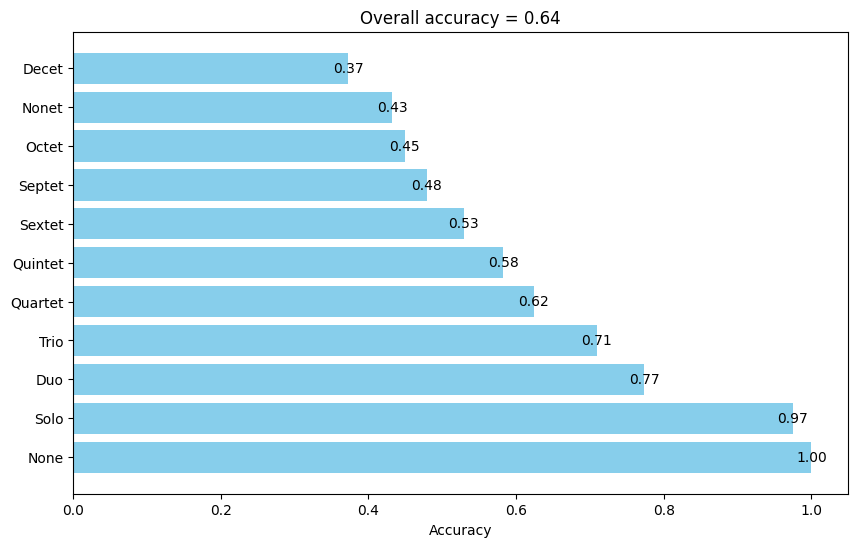

/content/drive/MyDrive/EMR_output/tests/threshold/0_emr[0.1327]_thresholds[1:0.0030-2:0.00071-3:0.1227-4:0.0075-5:0.0001-6:0.0001-7:0.0007-8:0.0018-9:0.0927-10:0.0056].csv


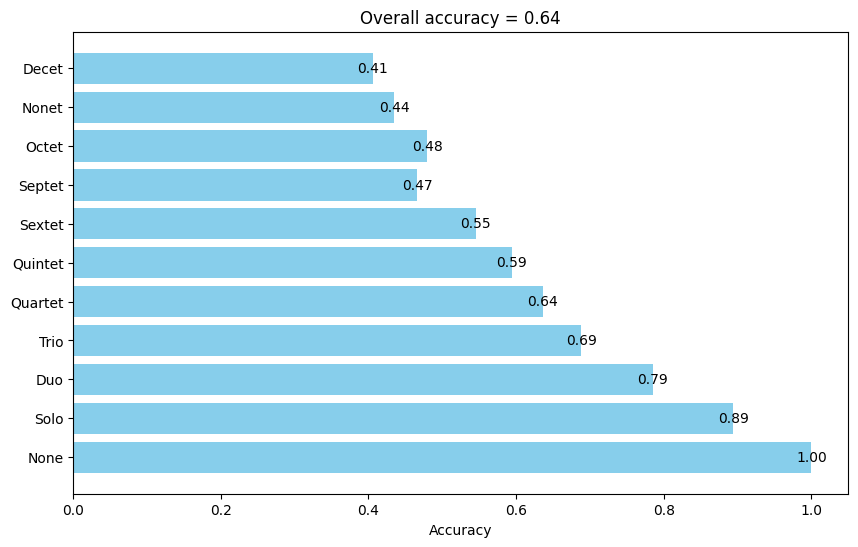

/content/drive/MyDrive/EMR_output/tests/threshold/0_emr[0.1318]_thresholds[1:0.0030-2:0.0007-3:0.1227-4:0.0075-5:0.0001-6:0.0007-7:0.0018-8:0.0100-9:0.0927-10:0.0056].csv


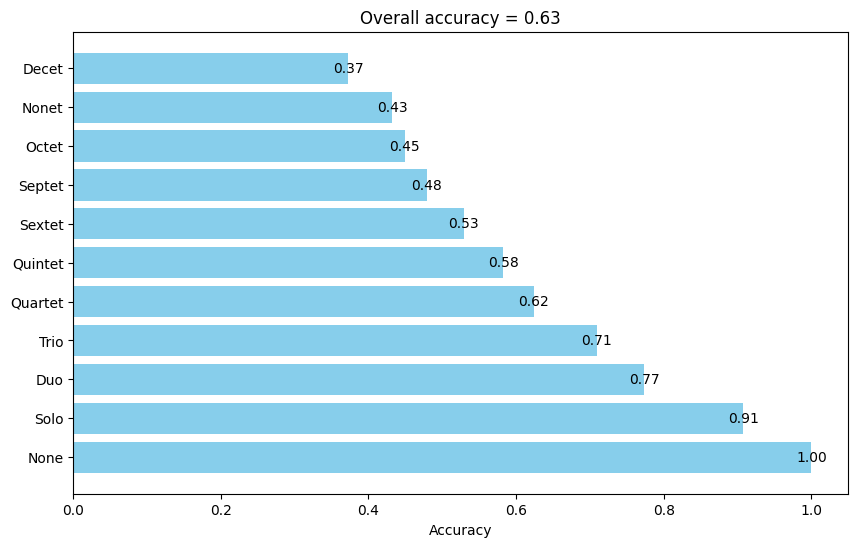

/content/drive/MyDrive/EMR_output/tests/threshold/1_emr[0.1712]_thresholds[1_0.0030-2_0.0007-3_0.1227-4_0.0075-5_0.0001-6_0.0007-7_0.0018-8_0.0100-9_0.0927-10_0.0056].csv


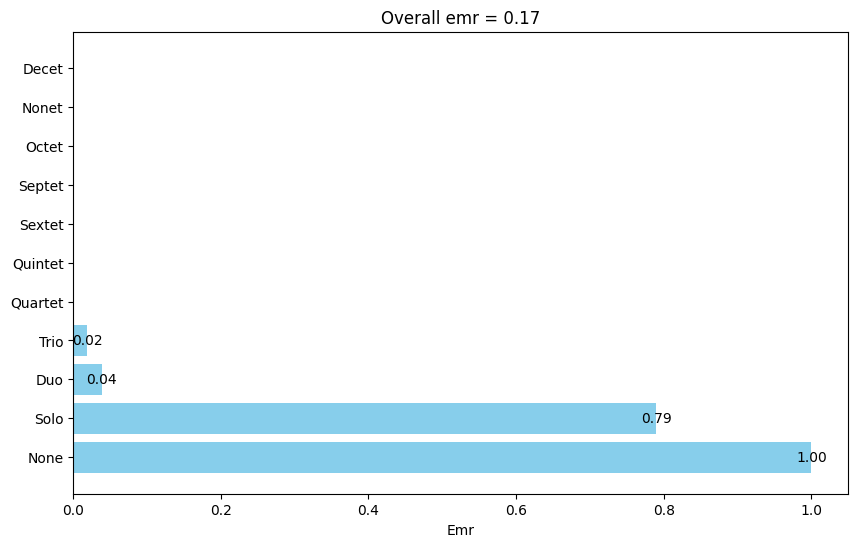

/content/drive/MyDrive/EMR_output/tests/threshold/0_emr[0.1327]_thresholds[1:0.0030-2:0.00071-3:0.1227-4:0.0075-5:0.0001-6:0.0001-7:0.0007-8:0.0018-9:0.0927-10:0.0056].csv


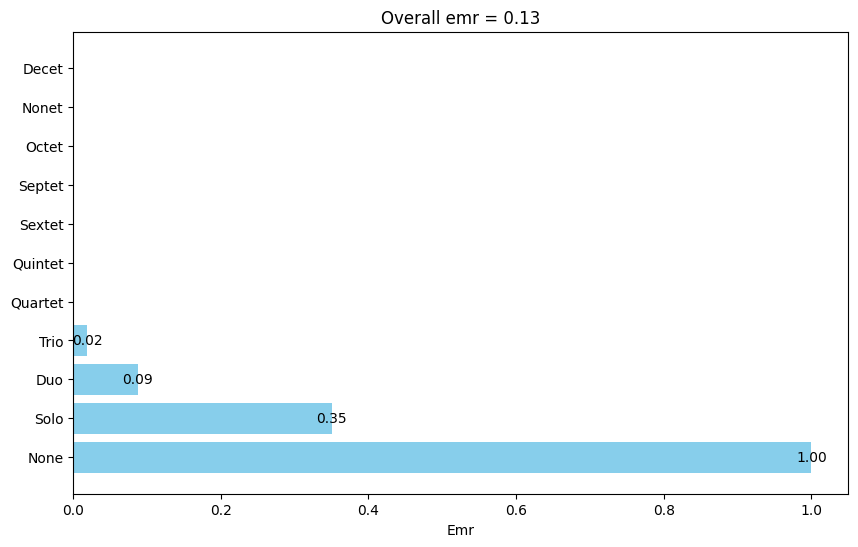

/content/drive/MyDrive/EMR_output/tests/threshold/0_emr[0.1318]_thresholds[1:0.0030-2:0.0007-3:0.1227-4:0.0075-5:0.0001-6:0.0007-7:0.0018-8:0.0100-9:0.0927-10:0.0056].csv


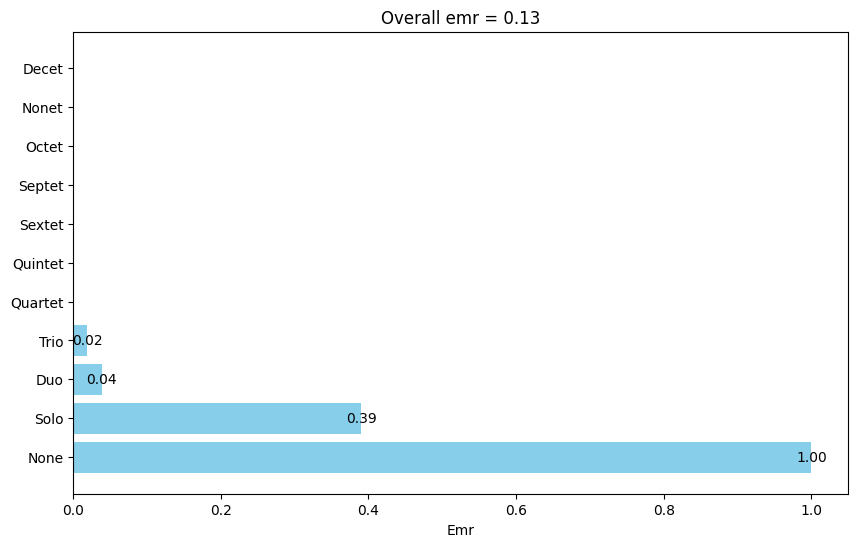

In [ ]:
import matplotlib.pyplot as plt

# Sort by overall accuracy and EMR in descending order
acc_tops = sorted(accuracy_emr_lists, key=lambda x: x['overall_accuracy'], reverse=True)
emr_tops = sorted(accuracy_emr_lists, key=lambda x: x['overall_emr'], reverse=True)

# Select top 10 for each
acc_tops_10 = acc_tops[:3]
emr_tops_10 = emr_tops[:3]


def plot_horizontal_barchart(individual, metric_type='accuracy'):
    # Extract accuracies or EMRs for all classes
    classes = ['no_instrument', '1_instruments', '2_instruments', '3_instruments',
               '4_instruments', '5_instruments', '6_instruments', '7_instruments',
               '8_instruments', '9_instruments', '10_instruments']
    values = [individual[f'{cls}_{metric_type}'] for cls in classes]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(classes, values, color='skyblue')
    plt.xlabel(metric_type.capitalize())
    plt.title(f"Overall {metric_type} = {individual[f'overall_{metric_type}']:.2f}")
    plt.yticks(ticks=range(len(classes)), labels=['None', 'Solo', 'Duo', 'Trio', 'Quartet',
                                                  'Quintet', 'Sextet', 'Septet', 'Octet',
                                                  'Nonet', 'Decet'])

    # Add the data values on the bars only if they are greater than 0.1
    for bar in bars:
        bar_width = bar.get_width()
        if bar_width > 0.01:
            plt.text(bar_width, bar.get_y() + bar.get_height()/2,
                     f'{bar_width:.2f}',
                     ha='center', va='center', fontsize=10, color='black')

    plt.show()



# Plot top 10 by accuracy
for individual in acc_tops_10:
    print(individual['file_path'])
    plot_horizontal_barchart(individual, metric_type='accuracy')

# Plot top 10 by EMR
for individual in acc_tops_10:
    print(individual['file_path'])
    plot_horizontal_barchart(individual, metric_type='emr')



confusion matrix


no_instrument
Bass Accuracy: 1.00, TPR: 1.00
Brass Accuracy: 1.00, TPR: 1.00
Flute Accuracy: 1.00, TPR: 1.00
Guitar Accuracy: 1.00, TPR: 1.00
Keyboard Accuracy: 1.00, TPR: 1.00
Mallet Accuracy: 1.00, TPR: 1.00
Organ Accuracy: 1.00, TPR: 1.00
Reed Accuracy: 1.00, TPR: 1.00
String Accuracy: 1.00, TPR: 1.00
Vocal Accuracy: 1.00, TPR: 1.00
1_instruments
Bass Accuracy: 1.00, TPR: 1.00
Brass Accuracy: 0.98, TPR: 1.00
Flute Accuracy: 0.97, TPR: 0.99
Guitar Accuracy: 0.97, TPR: 0.97
Keyboard Accuracy: 0.98, TPR: 0.99
Mallet Accuracy: 0.96, TPR: 0.96
Organ Accuracy: 0.97, TPR: 0.99
Reed Accuracy: 0.96, TPR: 0.98
String Accuracy: 0.96, TPR: 0.97
Vocal Accuracy: 1.00, TPR: 1.00
2_instruments
Bass Accuracy: 0.91, TPR: 0.90
Brass Accuracy: 0.78, TPR: 0.88
Flute Accuracy: 0.84, TPR: 0.85
Guitar Accuracy: 0.83, TPR: 0.87
Keyboard Accuracy: 0.71, TPR: 0.92
Mallet Accuracy: 0.80, TPR: 0.83
Organ Accuracy: 0.76, TPR: 0.81
Reed Accuracy: 0.69, TPR: 0.83
String Accuracy: 0.63, TPR: 0.88
Vocal Accuracy: 0.

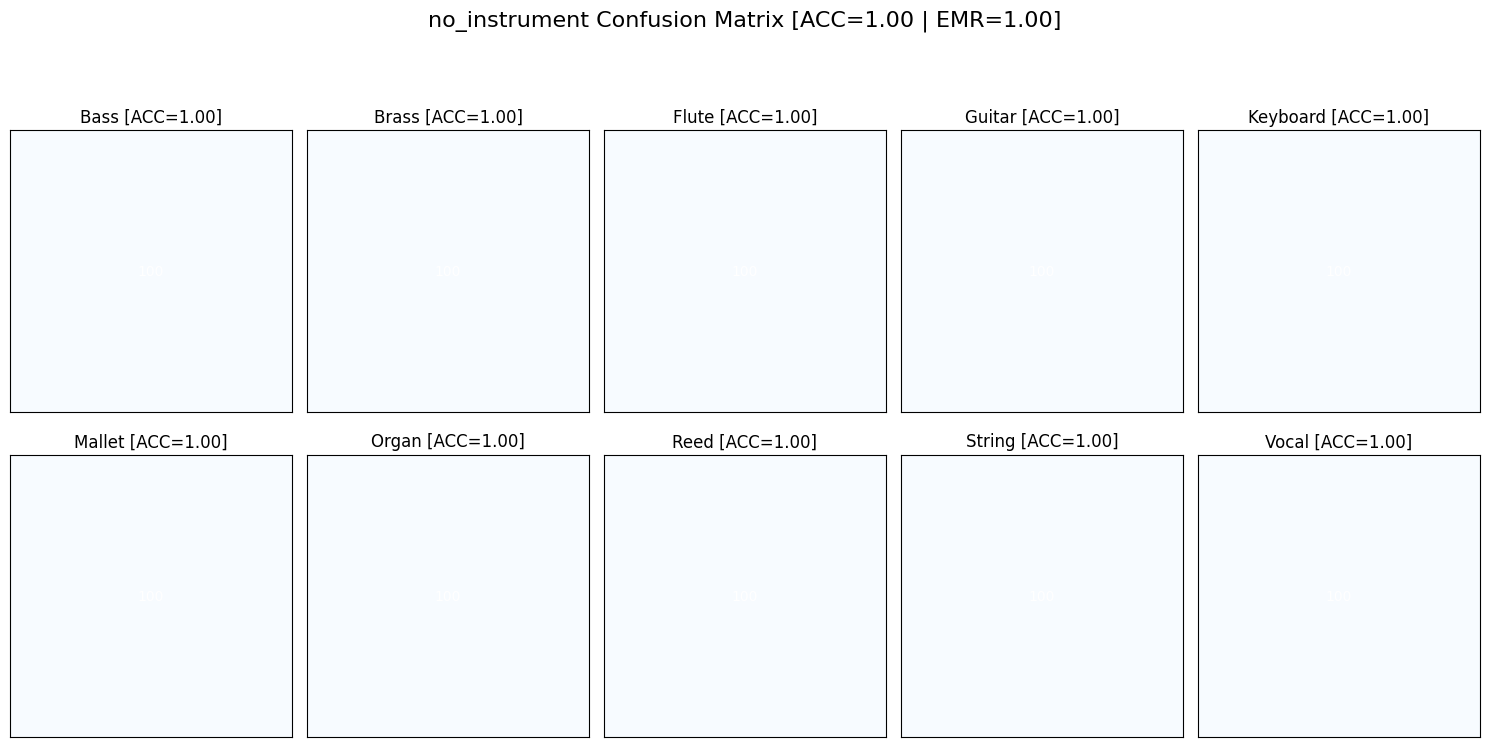

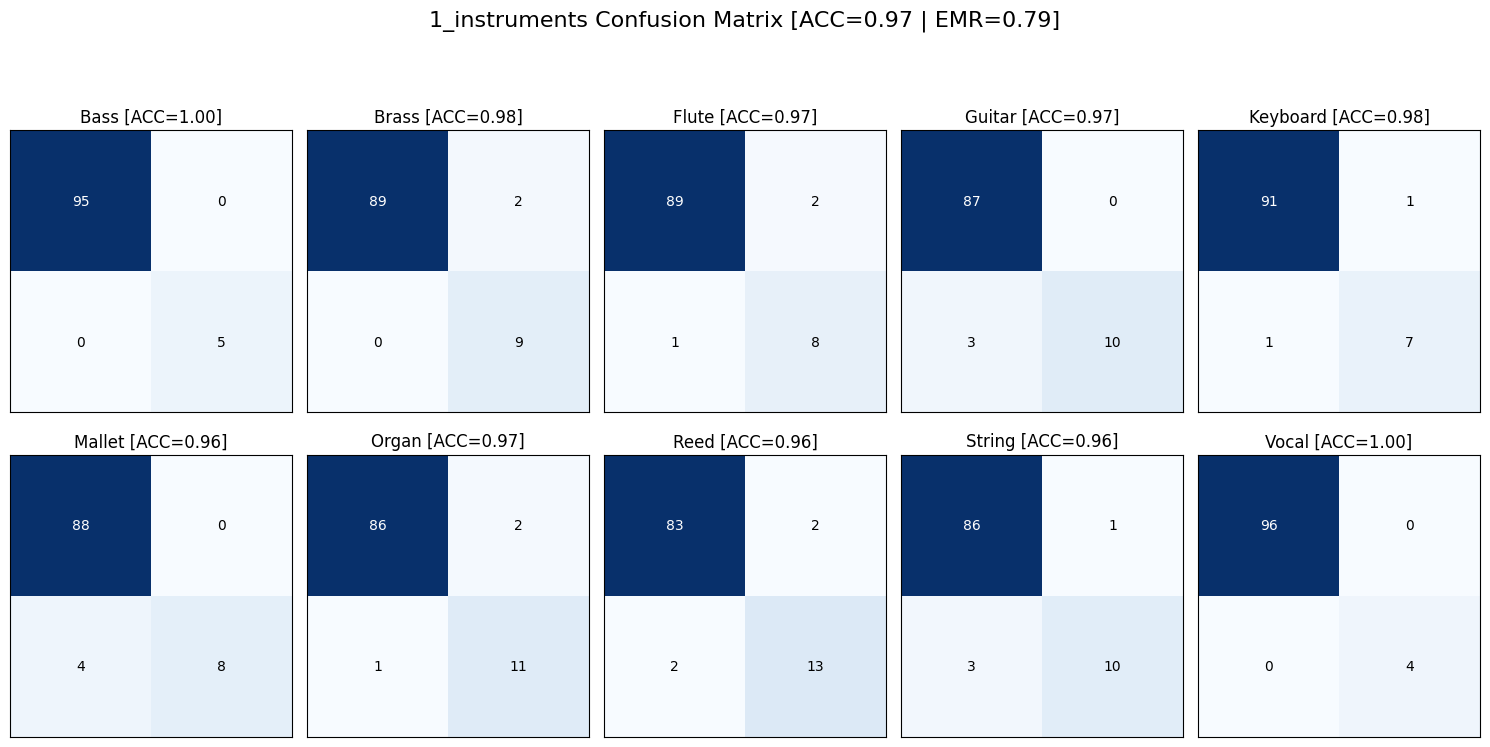

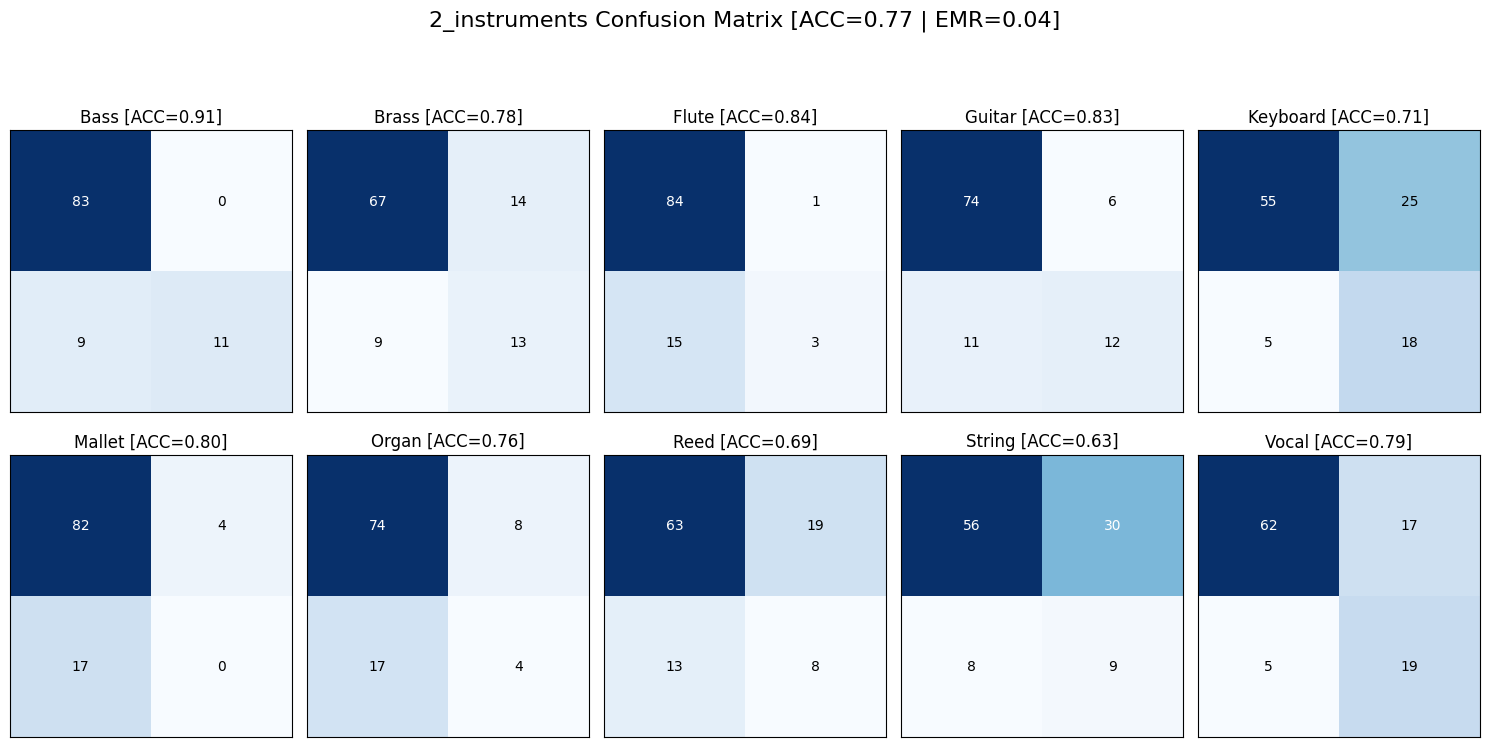

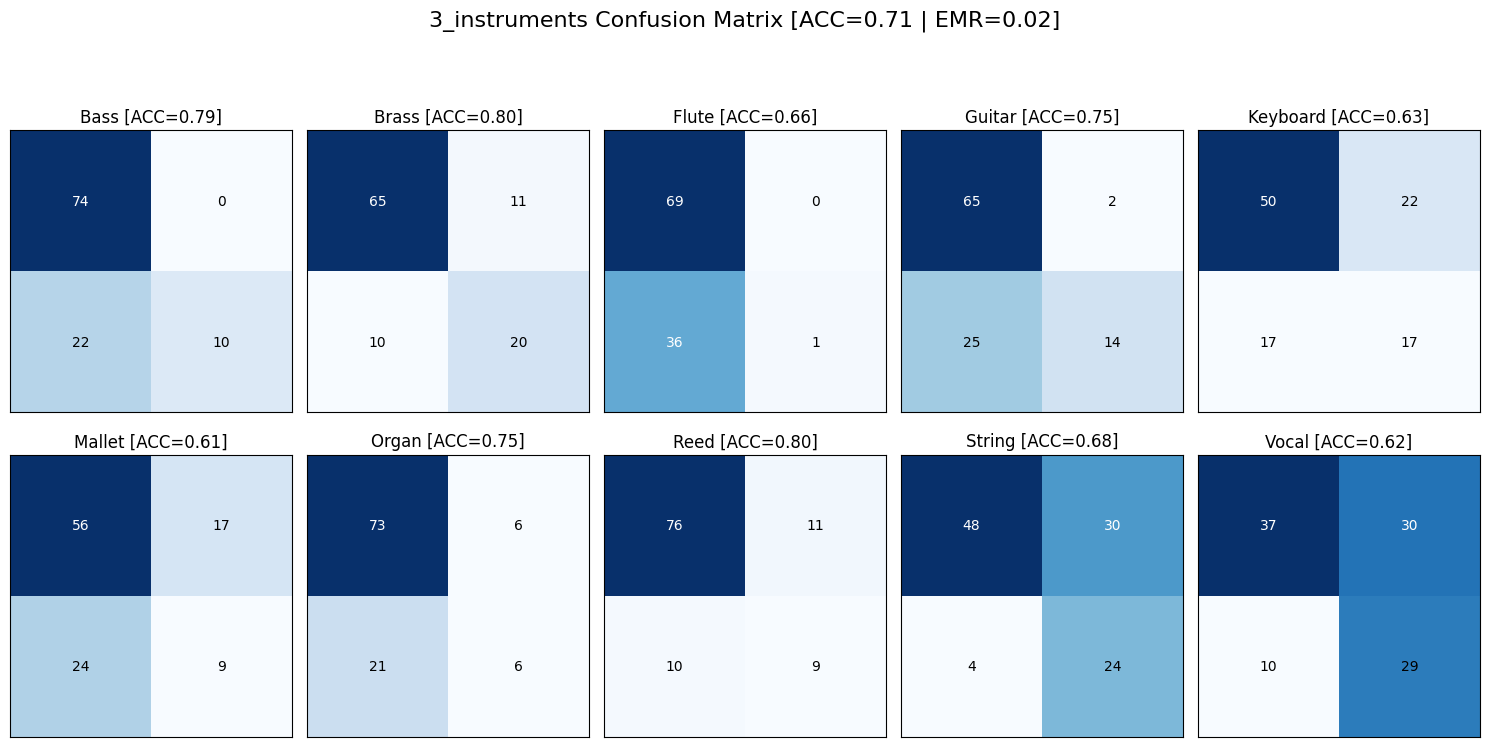

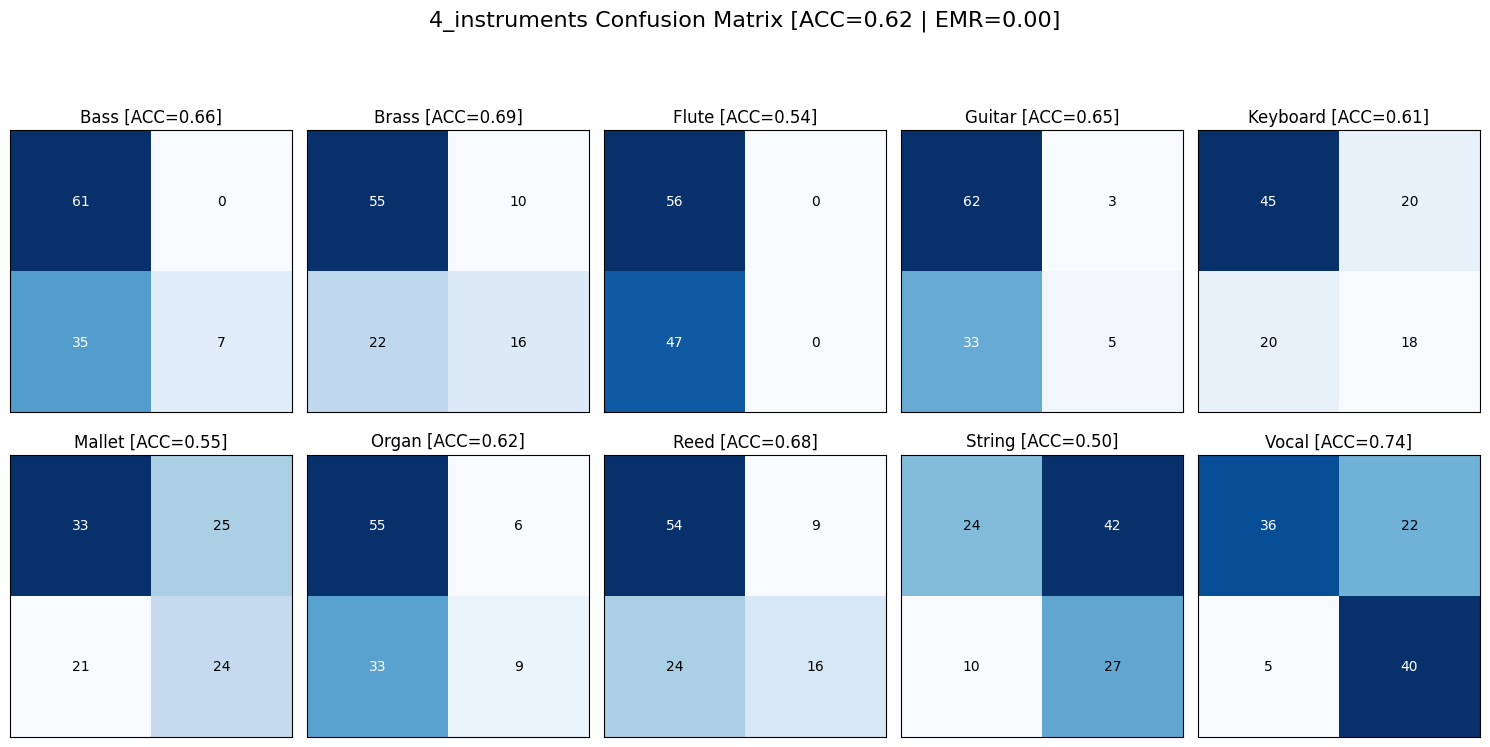

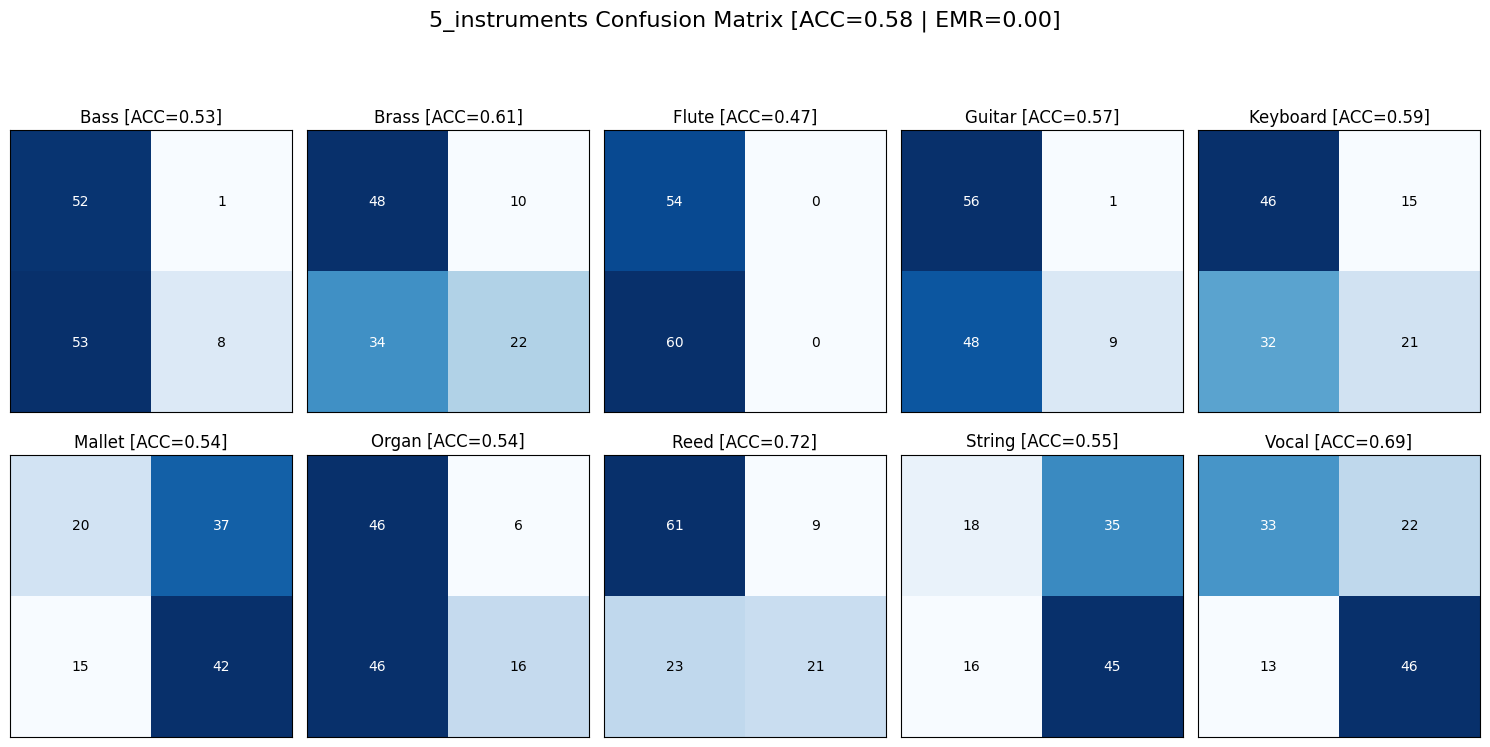

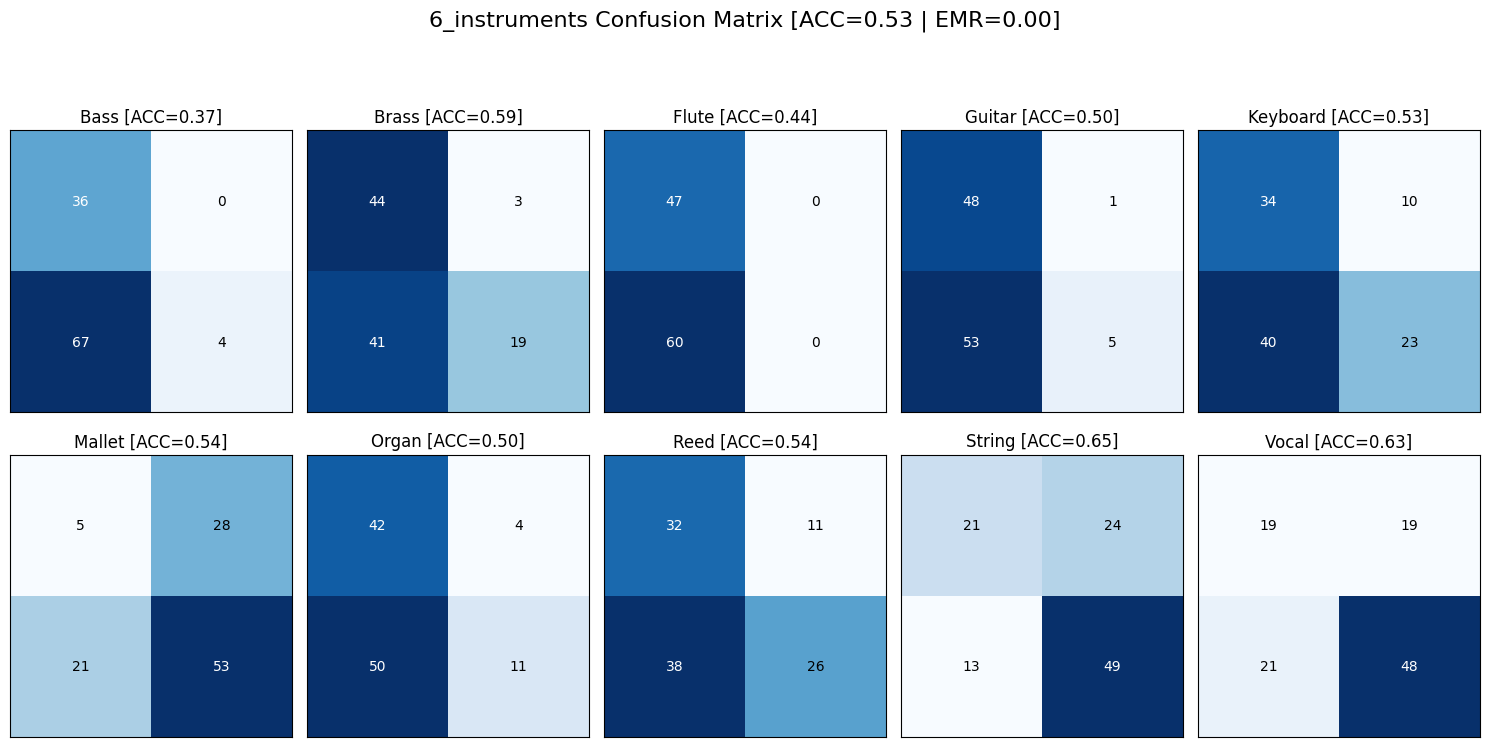

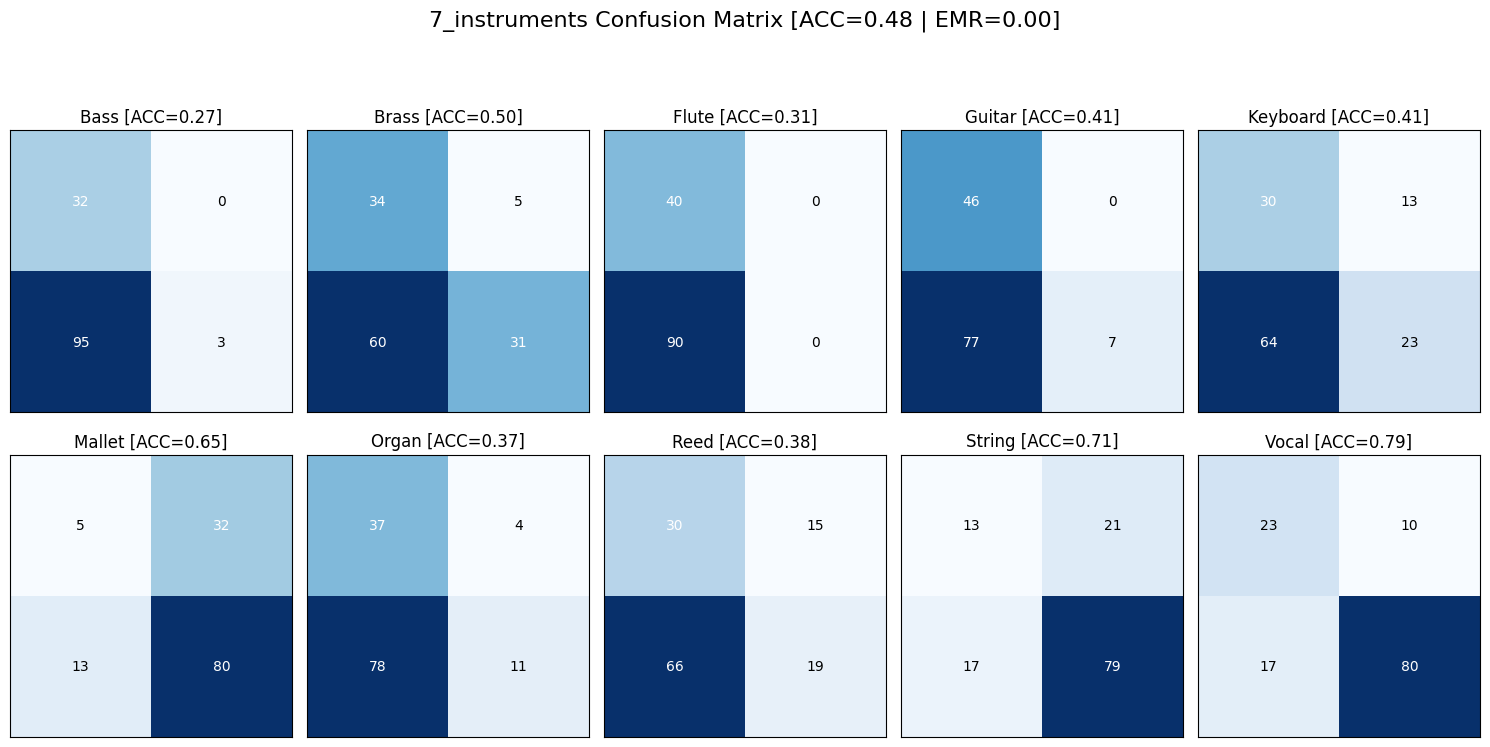

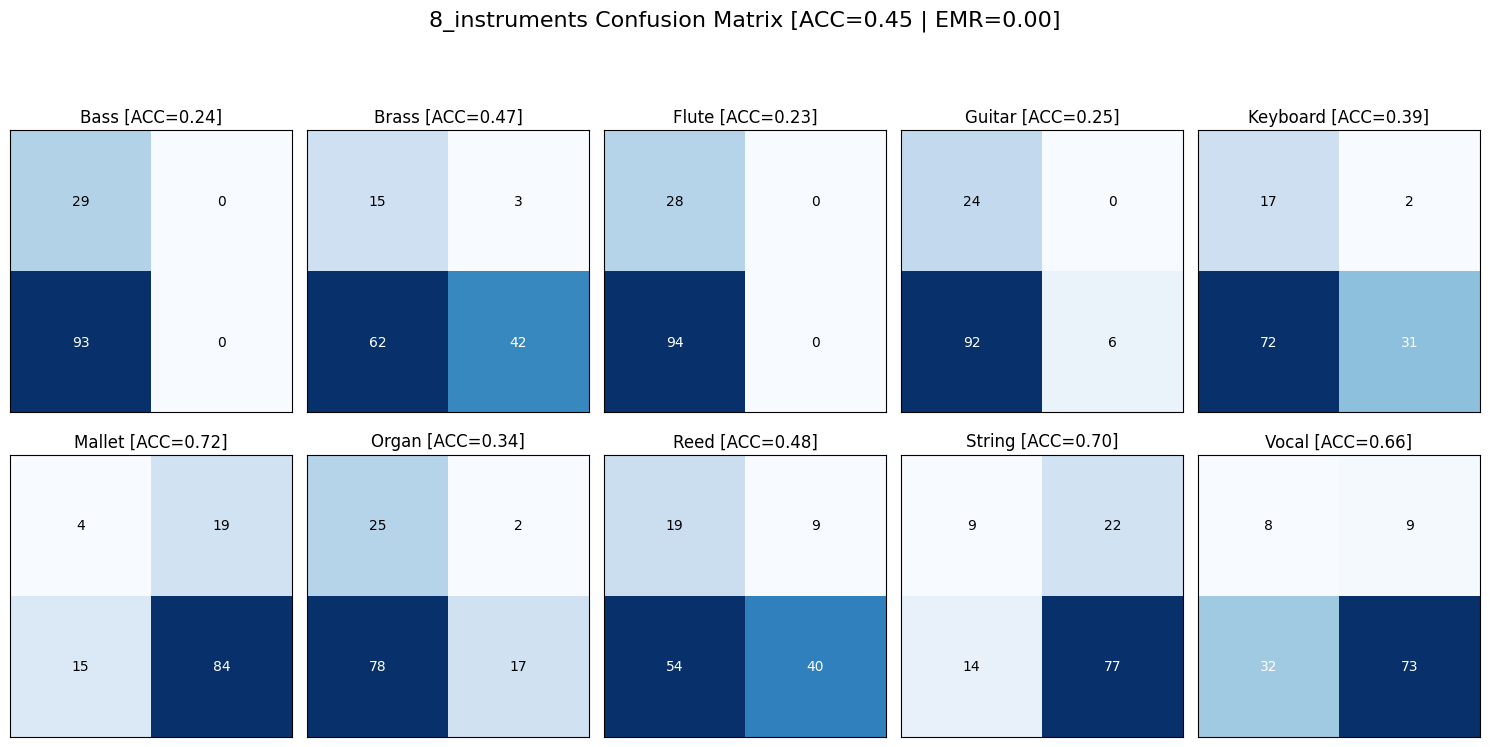

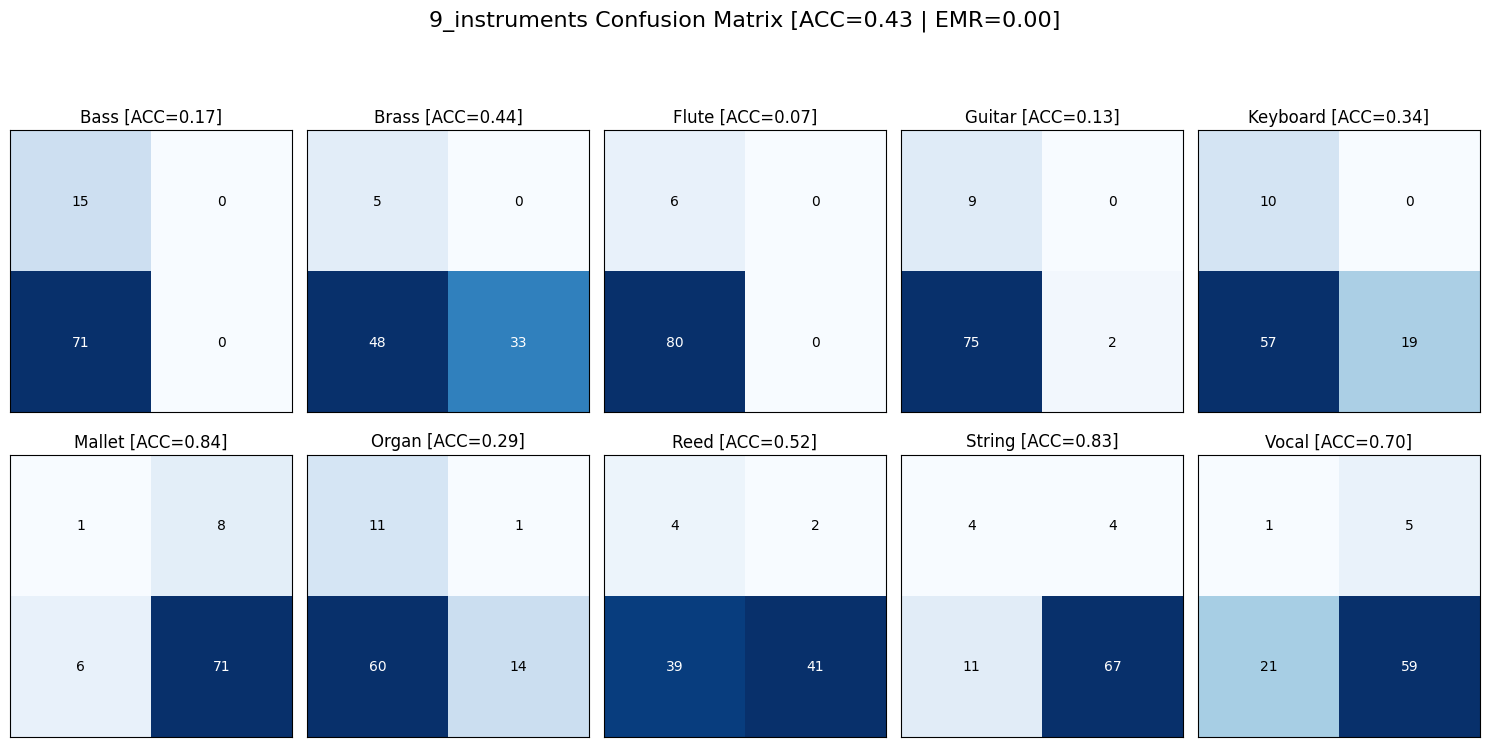

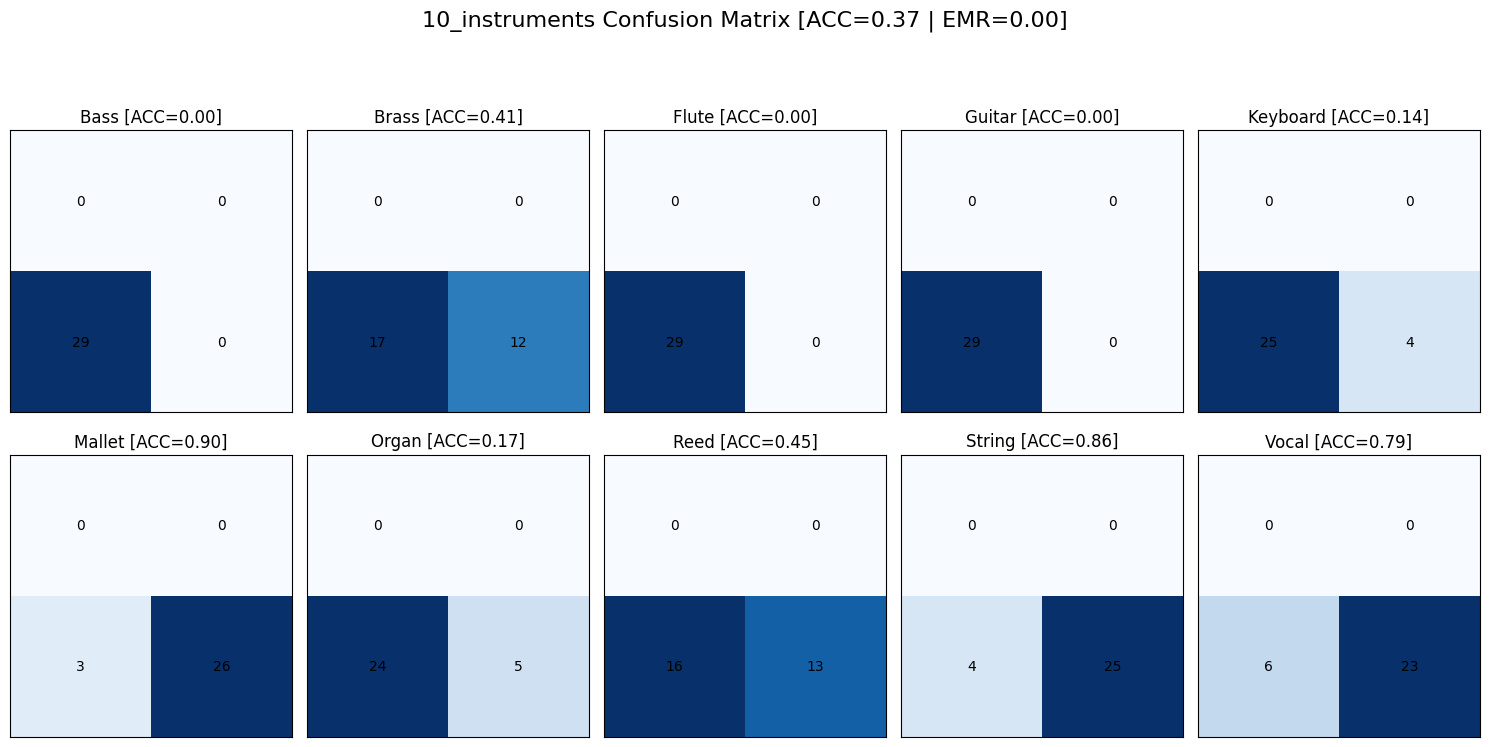

In [ ]:
import csv
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# We need to define the label map based on the third description of the file
label_map = {
    0: 'Bass',
    1: 'Brass',
    2: 'Flute',
    3: 'Guitar',
    4: 'Keyboard',
    5: 'Mallet',
    6: 'Organ',
    7: 'Reed',
    8: 'String',
    9: 'Vocal',
}

def calculate_tpr_from_conf_matrix(cfm):
    # Ensure the confusion matrix has the expected shape
    if cfm.shape == (2, 2):
        tp = cfm[0, 0]
        fn = cfm[1, 0]
        return tp / (tp + fn) if (tp + fn) != 0 else 0
    else:
        # This else block is for handling cases where the confusion matrix might not be 2x2
        # For example, if there were no positive samples, the confusion matrix might only contain true negatives.
        return 1.0  # Assuming perfect TPR if we can't calculate it

def show_confusion_matrix_and_acc(class_name, true_labels, pred_labels, overall_acc='', overall_emr=''):
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Smaller figure size for individual plots
    # fig, axes = plt.subplots(2, 5, figsize=(15, 20))  # Larger figure size for individual plots
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    fig.suptitle(f'{class_name} Confusion Matrix [ACC={overall_acc:.2f} | EMR={overall_emr:.2f}]', fontsize=16)
    print(class_name)
    # Iterate over each instrument and plot the confusion matrix
    for instrument_index in range(10):
        true_for_instrument = [label[instrument_index] for label in true_labels]
        pred_for_instrument = [label[instrument_index] for label in pred_labels]

        # Calculate the confusion matrix and individual accuracy and EMR for this instrument
        cfm = confusion_matrix(true_for_instrument, pred_for_instrument)
        tpr = calculate_tpr_from_conf_matrix(cfm)

        individual_acc = acc([true_for_instrument], [pred_for_instrument])

        print(f'{label_map[instrument_index]} Accuracy: {individual_acc:.2f}, TPR: {tpr:.2f}')
        # print(cfm)  # Print the confusion matrix to the console

        # Plot the confusion matrix
        axes[instrument_index].matshow(cfm, cmap='Blues')
        axes[instrument_index].set_title(f'{label_map[instrument_index]} [ACC={individual_acc:.2f}]')

        # Annotate the confusion matrix with text
        for (i, j), val in np.ndenumerate(cfm):
            color = 'white' if val >= 30 else 'black'
            fontweight = 'bold' if val >= 30 else 'normal'

            text = f"{val:.0f}" if val != 0 else "0"
            axes[instrument_index].text(j, i, text, ha='center', va='center', color=color) #  fontweight='

        axes[instrument_index].set_xticks([])
        axes[instrument_index].set_yticks([])

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Adjust top space to fit the suptitle
    # plt.show()

    # Check if the directory exists and if not, create it
    plot_cfm_save_dir = os.path.join(base_dir, 'cfm')
    if not os.path.exists(plot_cfm_save_dir):
        os.makedirs(plot_cfm_save_dir, exist_ok=True)

    # Save the figure
    plt.savefig(f'{plot_cfm_save_dir}/{class_name}_Confusion_Matrix.png')

# Read the file and prepare the true and predicted labels
def read_labels_from_file(file_path):
    true_labels, pred_labels = [], []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            true_labels.append([int(x) for x in row[0].split()])
            pred_labels.append([int(x) for x in row[1].split()])
    return true_labels, pred_labels

# Define the classify_labels_and_get_predictions function from previous context
# ...

# Use the file path for the best-performed file
best_file_path = '/content/drive/MyDrive/EMR_output/tests/threshold/1_emr[0.1712]_thresholds[1_0.0030-2_0.0007-3_0.1227-4_0.0075-5_0.0001-6_0.0007-7_0.0018-8_0.0100-9_0.0927-10_0.0056].csv'
true_labels, pred_labels = read_labels_from_file(best_file_path)



# Get the categories and predictions
categories = classify_labels_and_get_predictions(true_labels, pred_labels)

# Calculate and display the confusion matrix for each class
for i in range(12):  # Including 'decet'
    class_name = 'no_instrument' if i == 0 else ('decet' if i == 11 else f'{i}_instruments')
    class_true_labels = categories[i]['true_labels']
    class_pred_labels = categories[i]['pred_labels']

    overall_accuracy = acc(class_true_labels, class_pred_labels)
    overall_emr = emr(class_true_labels, class_pred_labels)

    if class_true_labels:  # Check if there are any true labels in this category
        show_confusion_matrix_and_acc(class_name, class_true_labels, class_pred_labels, overall_accuracy, overall_emr)


In [ ]:
    overall_accuracy = acc(true_labels,pred_labels)
    overall_emr = emr(true_labels, pred_labels)

    show_confusion_matrix_and_acc('Overall ', true_labels, pred_labels, overall_accuracy, overall_emr)


trend chart

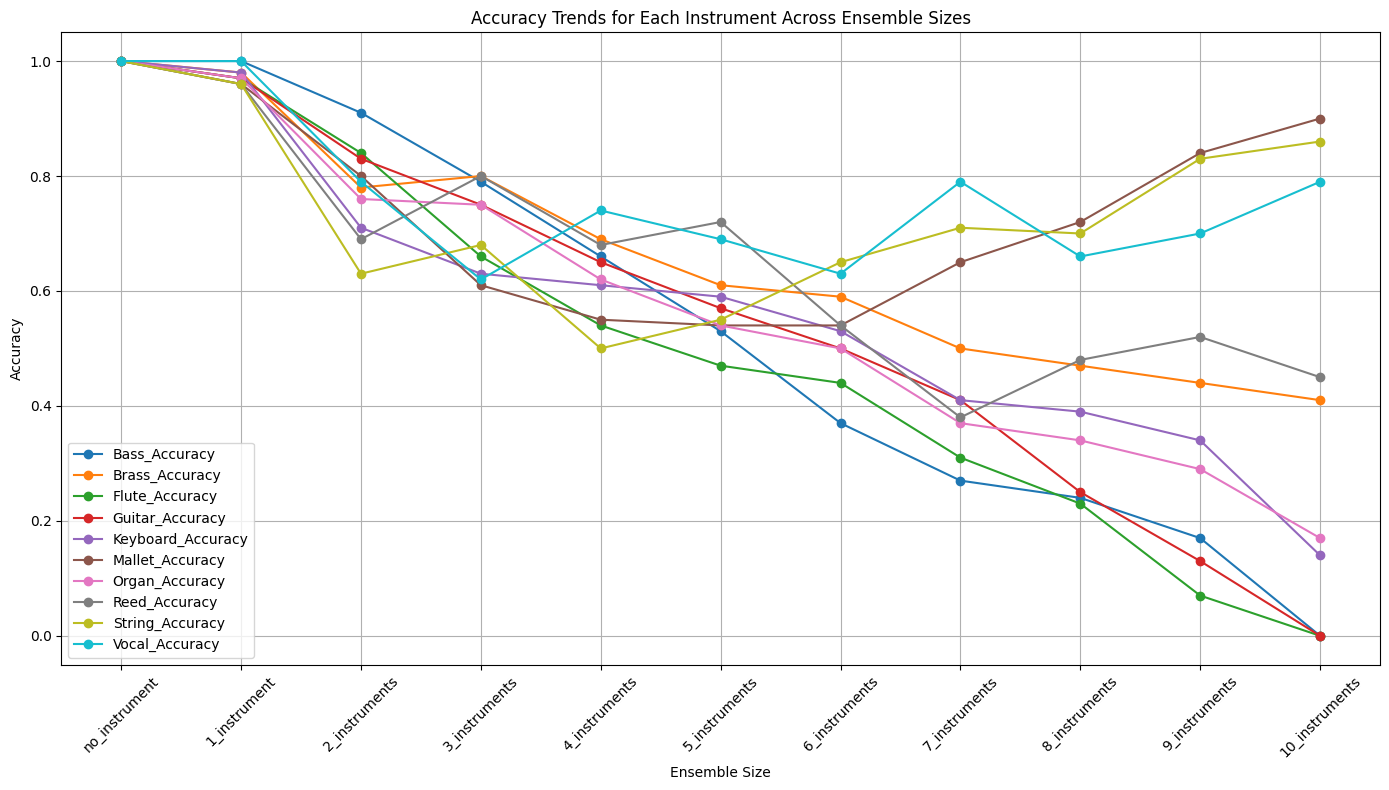

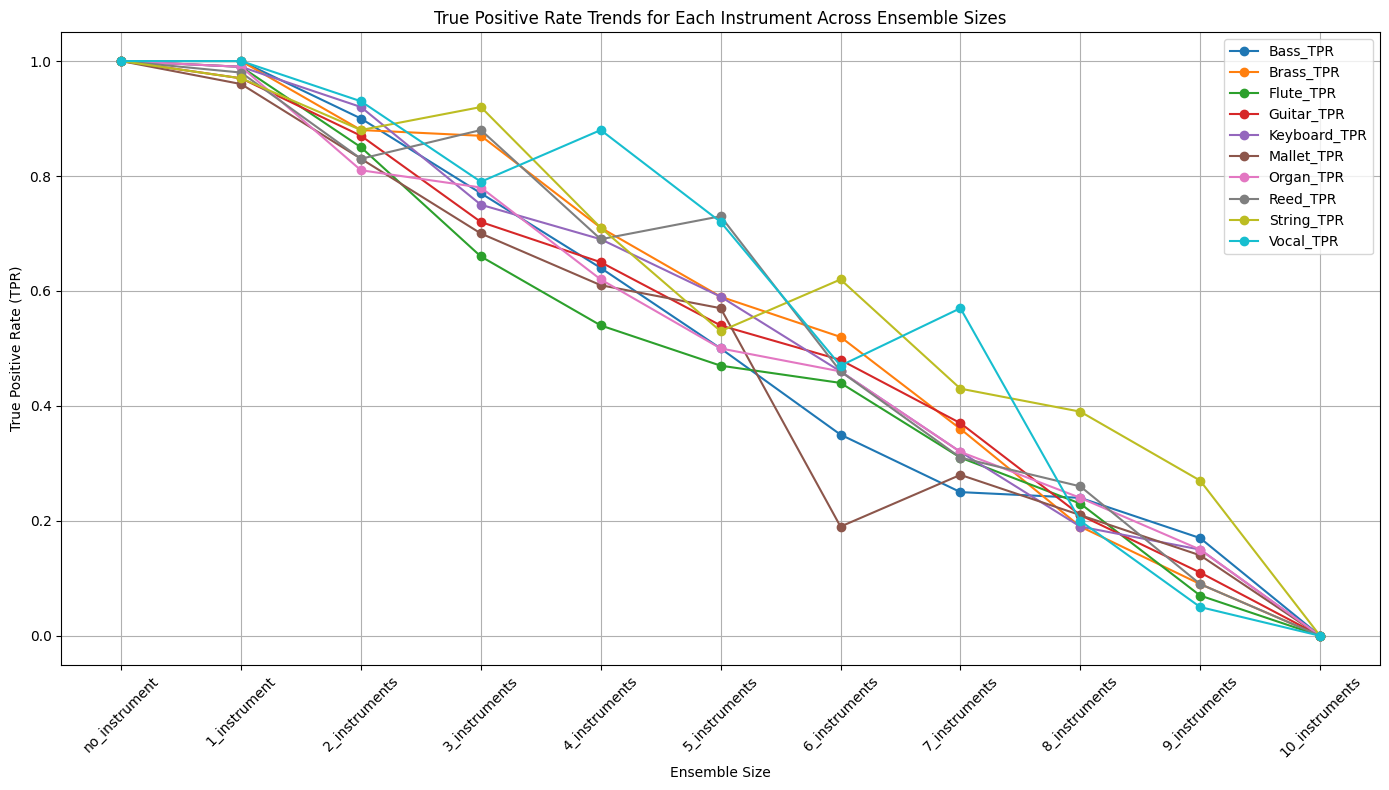

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import os
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt


data = {
    'Ensemble': ['no_instrument', '1_instrument', '2_instruments', '3_instruments', '4_instruments',
                 '5_instruments', '6_instruments', '7_instruments', '8_instruments', '9_instruments', '10_instruments'],
    'Bass_Accuracy': [1.00, 1.00, 0.91, 0.79, 0.66, 0.53, 0.37, 0.27, 0.24, 0.17, 0.00],
    'Brass_Accuracy': [1.00, 0.98, 0.78, 0.80, 0.69, 0.61, 0.59, 0.50, 0.47, 0.44, 0.41],
    'Flute_Accuracy': [1.00, 0.97, 0.84, 0.66, 0.54, 0.47, 0.44, 0.31, 0.23, 0.07, 0.00],
    'Guitar_Accuracy': [1.00, 0.97, 0.83, 0.75, 0.65, 0.57, 0.50, 0.41, 0.25, 0.13, 0.00],
    'Keyboard_Accuracy': [1.00, 0.98, 0.71, 0.63, 0.61, 0.59, 0.53, 0.41, 0.39, 0.34, 0.14],
    'Mallet_Accuracy': [1.00, 0.96, 0.80, 0.61, 0.55, 0.54, 0.54, 0.65, 0.72, 0.84, 0.90],
    'Organ_Accuracy': [1.00, 0.97, 0.76, 0.75, 0.62, 0.54, 0.50, 0.37, 0.34, 0.29, 0.17],
    'Reed_Accuracy': [1.00, 0.96, 0.69, 0.80, 0.68, 0.72, 0.54, 0.38, 0.48, 0.52, 0.45],
    'String_Accuracy': [1.00, 0.96, 0.63, 0.68, 0.50, 0.55, 0.65, 0.71, 0.70, 0.83, 0.86],
    'Vocal_Accuracy': [1.00, 1.00, 0.79, 0.62, 0.74, 0.69, 0.63, 0.79, 0.66, 0.70, 0.79],
    # Add TPR data here in a similar manner
}

df = pd.DataFrame(data)

# Plot accuracy for each instrument
plt.figure(figsize=(14, 8))
for column in df.columns[1:11]:  # Skip the first column which is 'Ensemble'
    plt.plot(df['Ensemble'], df[column], label=column, marker='o')
plt.title('Accuracy Trends for Each Instrument Across Ensemble Sizes')
plt.xlabel('Ensemble Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Similarly, plot TPR
data_2 = {
    'Ensemble': ['no_instrument', '1_instrument', '2_instruments', '3_instruments', '4_instruments',
                 '5_instruments', '6_instruments', '7_instruments', '8_instruments', '9_instruments', '10_instruments'],
    'Bass_TPR': [1.00, 1.00, 0.90, 0.77, 0.64, 0.50, 0.35, 0.25, 0.24, 0.17, 0.00],
    'Brass_TPR': [1.00, 1.00, 0.88, 0.87, 0.71, 0.59, 0.52, 0.36, 0.19, 0.09, 0.00],
    'Flute_TPR': [1.00, 0.99, 0.85, 0.66, 0.54, 0.47, 0.44, 0.31, 0.23, 0.07, 0.00],
    'Guitar_TPR': [1.00, 0.97, 0.87, 0.72, 0.65, 0.54, 0.48, 0.37, 0.21, 0.11, 0.00],
    'Keyboard_TPR': [1.00, 0.99, 0.92, 0.75, 0.69, 0.59, 0.46, 0.32, 0.19, 0.15, 0.00],
    'Mallet_TPR': [1.00, 0.96, 0.83, 0.70, 0.61, 0.57, 0.19, 0.28, 0.21, 0.14, 0.00],
    'Organ_TPR': [1.00, 0.99, 0.81, 0.78, 0.62, 0.50, 0.46, 0.32, 0.24, 0.15, 0.00],
    'Reed_TPR': [1.00, 0.98, 0.83, 0.88, 0.69, 0.73, 0.46, 0.31, 0.26, 0.09, 0.00],
    'String_TPR': [1.00, 0.97, 0.88, 0.92, 0.71, 0.53, 0.62, 0.43, 0.39, 0.27, 0.00],
    'Vocal_TPR': [1.00, 1.00, 0.93, 0.79, 0.88, 0.72, 0.47, 0.57, 0.20, 0.05, 0.00],
}

# Convert the dictionary into a DataFrame
df_2 = pd.DataFrame(data_2)

# Set the 'Ensemble' column as the index
df_2.set_index('Ensemble', inplace=True)

# Plot the TPR trends for each instrument
plt.figure(figsize=(14, 8))

for column in df_2.columns:
    plt.plot(df_2.index, df_2[column], label=column, marker='o')

plt.title('True Positive Rate Trends for Each Instrument Across Ensemble Sizes')
plt.xlabel('Ensemble Size')
plt.ylabel('True Positive Rate (TPR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
